In [73]:
from sklearn import datasets

iris = datasets.load_iris()

In [74]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, MaxAbsScaler, RobustScaler, QuantileTransformer
import numpy as np
from sklearn.model_selection import GridSearchCV

In [75]:
import matplotlib.pyplot as plt

In [76]:
X = iris.data
#y = [1] * 50 + [0] * 100
y = [0] * 50 + [1] * 50 + [0] * 50

In [77]:
X_scaled = MaxAbsScaler().fit_transform(X)
X_reduced = PCA(n_components=2).fit_transform(X_scaled)

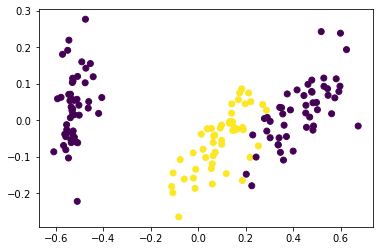

In [78]:
plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [79]:
import sys

sys.path.append('..')

from flod.classifiers.bsvclassifier import BSVClassifier

In [80]:
max_dist = 0
for i in X:
    for j in X:
        dist = np.linalg.norm(i-j, ord=2)**2
        if dist > max_dist:
            max_dist = dist

print(f'Suggested q: {1/max_dist}')

Suggested q: 0.019920318725099598


In [81]:
q = 10
p = 50

c = 1

print(f'p={1 / (c*len(X_reduced))}')

p=0.006666666666666667


In [82]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_reduced, y, test_size=0.33, shuffle=True, stratify=y)

In [83]:
clf = BSVClassifier(n_iter=10, q=q, penalization=200)
clf.fit(X_train, y_train)

BSVClassifier(n_iter=10, penalization=200, q=10)

In [84]:
y_pred = clf.predict(X_test)

In [85]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f'Precision {precision_score(y_test, y_pred)}')
print(f'Recall {recall_score(y_test, y_pred)}')
print(f'F1 {f1_score(y_test, y_pred)}')
print(f'Accuracy {accuracy_score(y_test, y_pred)}')

Precision 0.8
Recall 0.9411764705882353
F1 0.8648648648648648
Accuracy 0.9


In [86]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.97      0.88      0.92        33
           1       0.80      0.94      0.86        17

    accuracy                           0.90        50
   macro avg       0.88      0.91      0.89        50
weighted avg       0.91      0.90      0.90        50



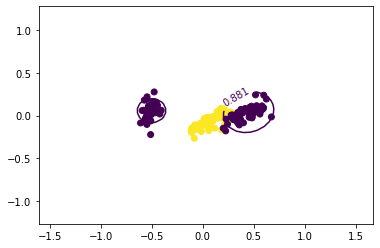

In [87]:
gx = np.linspace(min(X_reduced[:,0])-1, max(X_reduced[:,0])+1, 50)
gy = np.linspace(min(X_reduced[:,1])-1, max(X_reduced[:,1])+1, 50)
gX, gY = np.meshgrid(gx, gy)
zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
gZ = zs.reshape(gX.shape)
membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
plt.clabel(membership_contour, inline=1)

plt.scatter(X_reduced[:,0],X_reduced[:,1], c=y)
plt.show()

In [88]:
from joblib import dump, load
dump(clf, 'iris.joblib') 

['iris.joblib']

**Analizzare risultato di questa run in altro notebook**

Mi aspetto che esperimento qui sotto faccia schifo. C è uguale a 1 ma sto passando dei bsv.
Dovrei far si che training (aka solve optimization) lavori solo con dati con y = 0

In [89]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.33, shuffle=True, stratify=y)

In [90]:
from sklearn.pipeline import Pipeline
from sklearn.model_selection import StratifiedKFold


pipe = Pipeline([
        ('scaler', MaxAbsScaler()),
        ('reduce_dim', PCA()),
        ('classifier', BSVClassifier())
])

In [91]:
params = {
    #'scaler': [StandardScaler(), MaxAbsScaler(), RobustScaler(), QuantileTransformer()],
    'reduce_dim__n_components': range(iris.data.shape[1])[1:],
    'classifier__n_iter': [10],
    'classifier__penalization': np.random.uniform(1/max_dist, 100, 3),
    'classifier__q': np.random.uniform(1/max_dist, 100, 5)
}

scoring = ['precision', 'recall', 'f1']
cv = StratifiedKFold(n_splits=3, shuffle=True)
search = GridSearchCV(pipe, params, n_jobs=-1, cv=cv, refit='f1', verbose=5, return_train_score=True, scoring=scoring)

In [92]:
search.fit(X_train, y_train)

Fitting 3 folds for each of 45 candidates, totalling 135 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  9.3min
[Parallel(n_jobs=-1)]: Done 135 out of 135 | elapsed: 21.3min finished


GridSearchCV(cv=StratifiedKFold(n_splits=3, random_state=None, shuffle=True),
             estimator=Pipeline(steps=[('scaler', MaxAbsScaler()),
                                       ('reduce_dim', PCA()),
                                       ('classifier', BSVClassifier())]),
             n_jobs=-1,
             param_grid={'classifier__n_iter': [10],
                         'classifier__penalization': array([28.66833754, 59.09147679,  3.06933774]),
                         'classifier__q': array([ 3.75399521, 82.26358992, 36.03180935, 12.7234405 , 52.23384307]),
                         'reduce_dim__n_components': range(1, 4)},
             refit='f1', return_train_score=True,
             scoring=['precision', 'recall', 'f1'], verbose=5)

In [93]:
print(f'Best params: {search.best_params_}')
print(f'Best score: {search.best_score_}')

Best params: {'classifier__n_iter': 10, 'classifier__penalization': 28.668337538483254, 'classifier__q': 36.03180934747268, 'reduce_dim__n_components': 1}
Best score: 0.9274264382960036


In [94]:
search.score(X_test, y_test)

0.8666666666666666

In [109]:
import pandas as pd

cv_res = pd.DataFrame(search.cv_results_)
cv_res

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_classifier__n_iter,param_classifier__penalization,param_classifier__q,param_reduce_dim__n_components,params,split0_test_precision,...,split1_test_f1,split2_test_f1,mean_test_f1,std_test_f1,rank_test_f1,split0_train_f1,split1_train_f1,split2_train_f1,mean_train_f1,std_train_f1
0,31.476192,0.301834,0.087892,0.004317,10,28.6683,3.754,1,"{'classifier__n_iter': 10, 'classifier__penali...",0.833333,...,0.900000,0.594595,0.788053,0.137359,34,0.875000,0.857143,0.584615,0.772253,0.132880
1,31.218678,1.110310,0.084075,0.007552,10,28.6683,3.754,2,"{'classifier__n_iter': 10, 'classifier__penali...",0.666667,...,0.571429,0.578947,0.639869,0.091524,42,0.875000,0.717949,0.591549,0.728166,0.115944
2,31.900745,0.446234,0.109873,0.032051,10,28.6683,3.754,3,"{'classifier__n_iter': 10, 'classifier__penali...",0.625000,...,0.750000,0.564103,0.684948,0.085534,40,0.816327,0.800000,0.555556,0.723961,0.119267
3,32.652003,0.561869,0.092893,0.015450,10,28.6683,82.2636,1,"{'classifier__n_iter': 10, 'classifier__penali...",0.909091,...,0.909091,0.956522,0.924901,0.022359,2,0.954545,0.977778,0.926829,0.953051,0.020826
4,30.924595,1.116166,0.094333,0.001960,10,28.6683,82.2636,2,"{'classifier__n_iter': 10, 'classifier__penali...",1.000000,...,0.800000,0.761905,0.838095,0.082295,22,0.954545,0.933333,0.900000,0.929293,0.022451
5,30.137185,0.428239,0.084285,0.006411,10,28.6683,82.2636,3,"{'classifier__n_iter': 10, 'classifier__penali...",0.833333,...,0.800000,0.916667,0.862077,0.047922,15,0.930233,0.933333,0.851064,0.904877,0.038072
6,31.159370,0.521315,0.084280,0.006597,10,28.6683,36.0318,1,"{'classifier__n_iter': 10, 'classifier__penali...",0.909091,...,0.916667,0.956522,0.927426,0.020805,1,0.976744,0.936170,0.904762,0.939225,0.029466
7,30.718527,0.815640,0.085081,0.004729,10,28.6683,36.0318,2,"{'classifier__n_iter': 10, 'classifier__penali...",0.916667,...,0.800000,0.800000,0.852174,0.073785,19,0.933333,0.897959,0.833333,0.888209,0.041403
8,31.005060,0.583961,0.078571,0.004762,10,28.6683,36.0318,3,"{'classifier__n_iter': 10, 'classifier__penali...",0.888889,...,0.833333,0.846154,0.826496,0.019453,25,0.930233,0.933333,0.800000,0.887855,0.062136
9,30.960052,0.544836,0.084983,0.001655,10,28.6683,12.7234,1,"{'classifier__n_iter': 10, 'classifier__penali...",0.909091,...,0.916667,0.761905,0.862554,0.071237,13,0.954545,0.936170,0.850000,0.913572,0.045574


In [96]:
clf = search.best_estimator_['classifier']

In [97]:
# TO CHECK PCA NUMBER OF COMPONENTS BEFORE PLOTTING
# gx = np.linspace(min(clf.X_[:,0])-1, max(clf.X_[:,0])+1, 50)
# gy = np.linspace(min(clf.X_[:,1])-1, max(clf.X_[:,1])+1, 50)
# gX, gY = np.meshgrid(gx, gy)
# zs = np.array([clf._compute_r(np.array([x, y])) for x, y in zip(np.ravel(gX), np.ravel(gY))])
# gZ = zs.reshape(gX.shape)
# membership_contour = plt.contour(gX, gY, gZ, levels=(clf.radiuses_[clf.sv_i], ))
# plt.clabel(membership_contour, inline=1)

# plt.scatter(clf.X_[:,0], clf.X_[:,1], c=clf.y_)
# plt.show()

In [98]:
from sklearn.metrics import classification_report

print(classification_report(y_test, search.predict(X_test)))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94        33
           1       1.00      0.76      0.87        17

    accuracy                           0.92        50
   macro avg       0.95      0.88      0.90        50
weighted avg       0.93      0.92      0.92        50



In [99]:
dump(clf, 'grid_iris.joblib') 

['grid_iris.joblib']

In [100]:
columns = [col for col in cv_res.columns if 'mean' in col and 'test' in col]
columns.append('param_classifier__q')
columns.append('param_reduce_dim__n_components')

In [124]:
cv_res_fil = cv_res[cv_res['param_classifier__penalization'] == search.best_params_['classifier__penalization']][columns]
cv_res_fil = cv_res_fil[cv_res_fil['param_reduce_dim__n_components'] == search.best_params_['reduce_dim__n_components']]
cv_res_fil= cv_res_fil.drop('param_reduce_dim__n_components', axis=1)

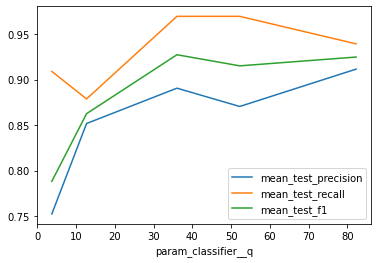

In [131]:
cv_res_fil.sort_values('param_classifier__q', axis=0).plot(x='param_classifier__q')
plt.show()